In [1]:
import os

try:
    snakemake
except NameError:
    from snakemk_util import load_rule_args
    
    os.chdir('../..')
    
    snakemake = load_rule_args(
        snakefile = os.getcwd() + "/workflow/Snakefile",
        rule_name = 'compare_lapa_polya_atlas',
        root = '..',
        default_wildcards={'sample': 'wtc11'}
    )

In [2]:
import numpy as np
import pandas as pd
import pyranges as pr
import seaborn as sns
import matplotlib.pyplot as plt

from lapa.result import LapaResult

In [3]:
def read_polya_atlas(path):
    df = pr.read_bed(path, as_df=True)
    df = df.rename(columns={'Score': 'tpm', 'ThickStart': 'usage', 
                            'ThickEnd': 'num_protocol', 'ItemRGB': 'tpm_ave', 
                            'BlockCount': 'annotation', 'BlockSizes': 'signal'})
    return df

In [4]:
top_n = 100_000

In [5]:
def moving_sum_signal(df, rolling_window=10000, lack_signal='None@None'):
    agg_func = {'signal_support': 'mean', 'rank': 'mean'}
    df = df[['signal_support', 'rank']].sort_values('rank', ascending=False).rolling(rolling_window).agg(agg_func)
    return df

In [6]:
def sns_lineplot_std(data, x, y, std):
    
    lower_bound = data[y] - data[std]
    upper_bound = data[y] + data[std]

    sns.lineplot(data=data, x=x, y=y)
    plt.fill_between(data[x], lower_bound.values, upper_bound.values, alpha=.3)
    
    return data[x], lower_bound, upper_bound

In [7]:
polya_atlas = [
    read_polya_atlas(path)
    for path in snakemake.input['polya_atlas']
]

In [8]:
df_end = LapaResult(snakemake.input['lapa_end'], tpm_cutoff=0).read_cluster() \
    .drop_duplicates(['Chromosome', 'Start', 'End', 'Strand'])
df_end = df_end[df_end['Chromosome'].str.startswith('chr')]

Text(0.5, 0, 'Ranked by expression')

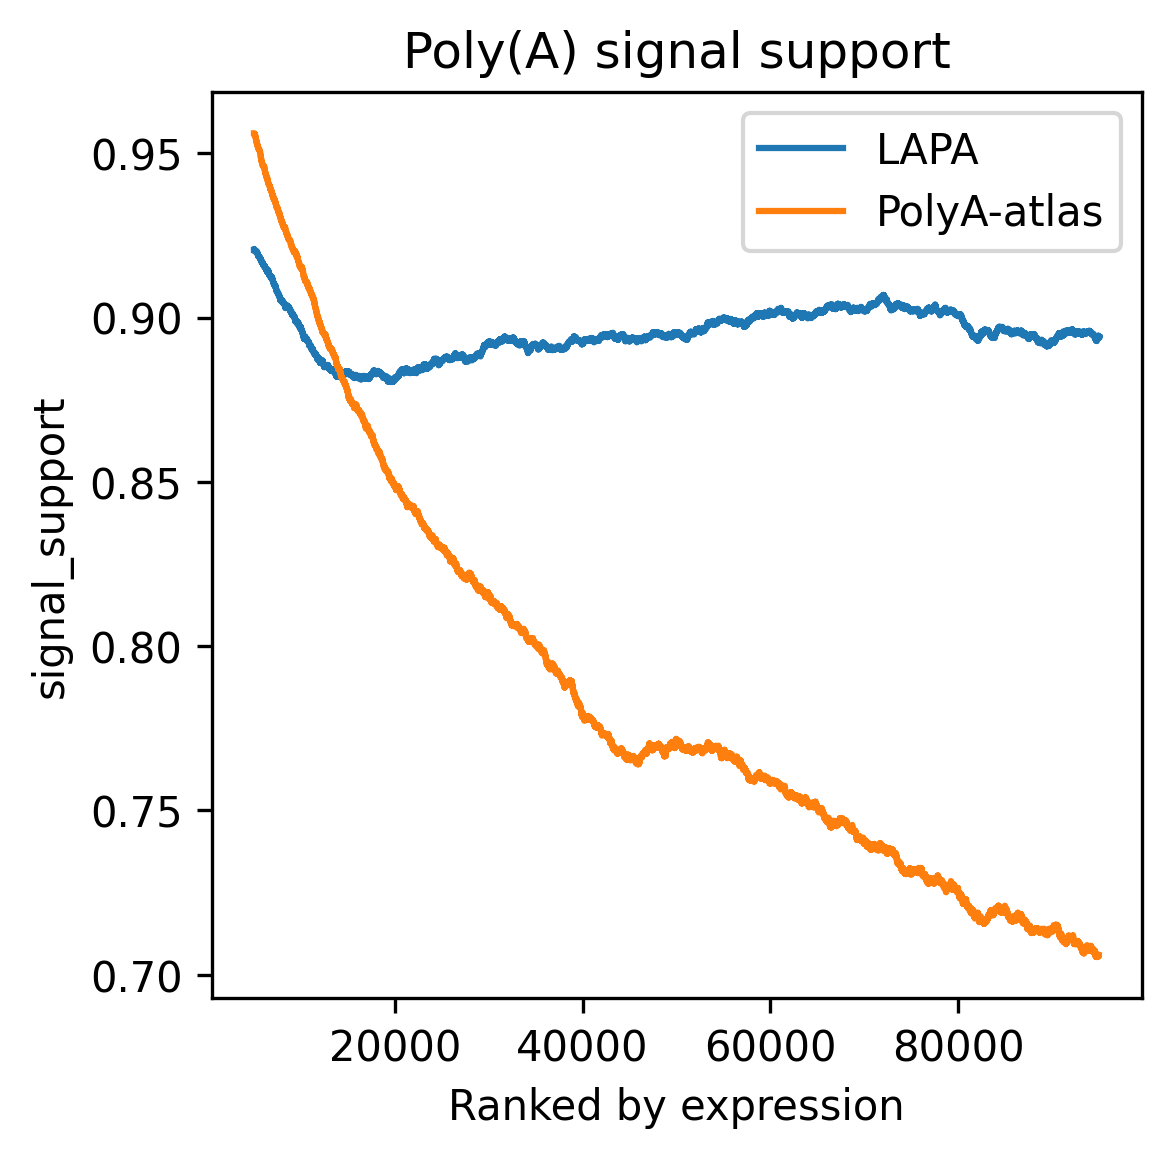

In [9]:
plt.figure(figsize=(4, 4), dpi=300)

_df = df_end.copy()
_df['signal_support'] = _df['signal'] != 'None@None'
_df['rank'] = _df['tpm'].rank(ascending=False)
_df = _df.sort_values('rank')[:top_n] 
_df = moving_sum_signal(_df)
sns.lineplot(data=_df, x='rank', y='signal_support')

_df = polya_atlas[0].copy()
_df['signal_support'] = ~_df.signal.isna()
_df['rank'] = _df['tpm_ave'].rank(ascending=False)
_df = _df.sort_values('rank')[:top_n]
_df = moving_sum_signal(_df)
sns.lineplot(data=_df, x='rank', y='signal_support')

plt.legend(['LAPA', 'PolyA-atlas'])

plt.title('Poly(A) signal support')
plt.xlabel('Ranked by expression')
# plt.ylim((0.7, 1))

In [11]:
df_end = LapaResult(snakemake.input['lapa_end'], tpm_cutoff=0) \
    .read_cluster(filter_internal_priming=False) \
    .drop_duplicates(['Chromosome', 'Start', 'End', 'Strand'])

In [12]:
#df_end_filter = df_end.sort_values('count', ascending=False)[:top_n]
df_atlas_filter = polya_atlas[0].copy().sort_values('tpm_ave', ascending=False)[:top_n]

In [13]:
df_join = pr.PyRanges(df_atlas_filter.reset_index(), int64=True).nearest(
    pr.PyRanges(df_end.reset_index(), int64=True), strandedness='same'
).df

In [14]:
_df = df_join[df_join['Distance'] > 100].sort_values('tpm_ave', ascending=False)
_df[~_df['signal'].isna()].shape[0]

109

In [15]:
_df.sort_values('tpm_ave', ascending=False)

,index,Chromosome,Start,End,Name,tpm,Strand,usage,num_protocol,tpm_ave,...,End_b,polyA_site,tpm_b,Strand_b,Feature,count,fracA,signal_b,canonical_site,Distance
43979,354477,chr7,100940570,100940601,chr7:100940591:-,0.1936,-,1.00,1,0.2914,...,100941017,100941017,0.051258,-,intergenic,4,9,None@None,-1,416
78830,136661,chr16,11457704,11457729,chr16:11457717:-,0.1291,-,1.00,1,0.2234,...,11459214,11459214,0.089701,-,intron,7,10,None@None,-1,1485
27899,287171,chr4,129034147,129034161,chr4:129034148:-,0.3227,-,1.00,1,0.2180,...,129034843,129034843,0.166588,-,intron,13,2,129034882@AATAAA,-1,682
25718,292039,chr4,181089236,181089247,chr4:181089240:+,0.1291,+,1.00,1,0.2059,...,181089721,181089721,0.102516,+,intergenic,8,10,None@None,-1,474
95188,242669,chr22,41872479,41872501,chr22:41872501:+,0.1291,+,1.00,1,0.2059,...,41872249,41872249,2.626971,+,intron,205,10,None@None,-1,231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36428,321704,chr6,28093761,28093794,chr6:28093777:+,0.0645,+,1.00,1,0.1322,...,28093611,28093611,0.115330,+,exon,9,3,28093612@ATTAAA,-1,151
38769,327164,chr6,57189826,57189843,chr6:57189841:-,0.0645,-,1.00,1,0.1319,...,57188943,57188943,0.038443,-,three_prime_utr,3,1,57188984@ACTAAA,57186991,884
68608,96621,chr13,26132114,26132131,chr13:26132115:-,0.0645,-,1.00,1,0.1319,...,26144392,26144392,0.038443,-,intron,3,10,None@None,-1,12261
72003,108414,chr14,31020734,31020758,chr14:31020757:-,0.0645,-,1.00,1,0.1319,...,31019908,31019900,5.740893,-,intron,448,10,31019956@AAGAAA,-1,827


## Replications

In [16]:
df_tpm_atlas = pd.concat([
    df[['tpm']].rename(columns={'tpm': f'tpm_{i}'})
    for i, df in enumerate(polya_atlas)
], axis=1)

df_tpm_atlas
#df_rep_atlas['tpm_ave'] = df_rep_atlas.mean(axis=1)
#df_rep_atlas['replication'] = (df_rep_atlas[['tpm_0', 'tpm_1', 'tpm_2']] > 0).sum(axis=1)
#df_rep_atlas = df_rep_atlas[['replication', 'tpm_ave']].sort_values('tpm_ave').rolling(10000).mean()
#df_rep_atlas['rank'] = df_rep_atlas['tpm_ave'].rank(ascending=False)

,tpm_0,tpm_1,tpm_2
0,0.0000,0.2787,0.0000
1,3.4202,1.8115,5.7750
2,0.0000,0.0000,0.1050
3,0.1936,0.0000,0.0000
4,0.0000,0.0000,0.1050
...,...,...,...
415547,0.0000,0.0000,0.0525
415548,0.0000,0.0000,0.0525
415549,0.0000,0.0697,0.0000
415550,0.0645,0.0000,0.0000


In [17]:
from lapa.result import LapaResult

result_end = LapaResult(snakemake.input['lapa_end'], tpm_cutoff=0)
df_count_lapa = result_end.counts()
df_count_lapa

,WTC11_1,WTC11_3,WTC11_2
name,,,
ERCC-00002:1045:+,50.0,27.0,54.0
ERCC-00003:1007:+,4.0,4.0,3.0
ERCC-00004:507:+,22.0,12.0,18.0
ERCC-00022:735:+,NaN,NaN,3.0
ERCC-00043:1007:+,2.0,1.0,NaN
...,...,...,...
chrY:5717394:+,NaN,3.0,NaN
chrY:5739583:+,NaN,NaN,8.0
chrY:5740171:+,NaN,1.0,3.0


In [18]:
def replication_rate(df, moving_average=True):
    df = df.copy()
    cols = df.columns
    df['mean'] = df.mean(axis=1)
    df['replication'] = (df[cols] > 0).mean(axis=1)
    
    if moving_average:
        df = df[['replication', 'mean']].sort_values('mean', ascending=False).rolling(10000).mean()
    
    df['rank'] = df['mean'].rank(ascending=False)
    return df

Text(0, 0.5, 'Replication moving average')

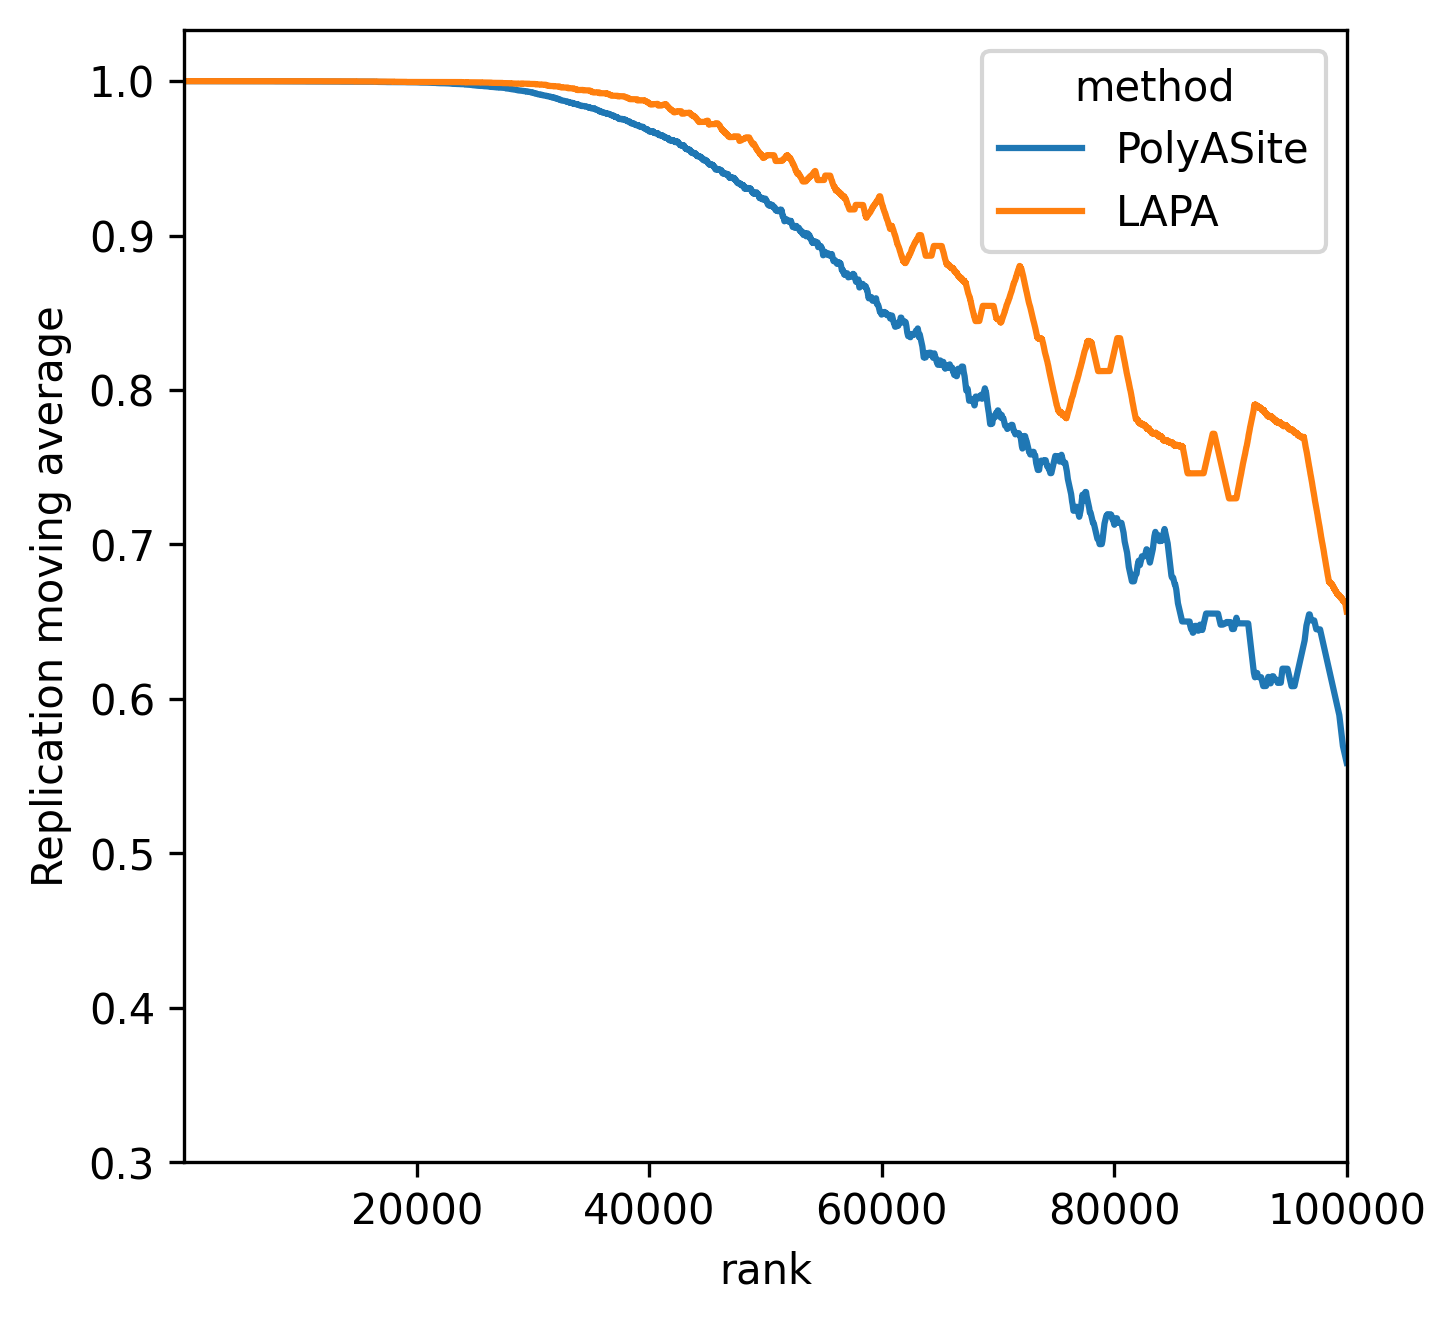

In [19]:
plt.figure(figsize=(5, 5), dpi=300)

df_rep_atlas = replication_rate(df_tpm_atlas).assign(method='PolyASite')
df_rep_lapa = replication_rate(df_count_lapa).assign(method='LAPA')

sns.lineplot(data=pd.concat([df_rep_atlas, df_rep_lapa], axis=0), x='rank', y='replication', hue='method')

plt.xlim((1, top_n))
plt.ylabel('Replication moving average')

In [20]:
df_rep_atlas = replication_rate(df_tpm_atlas, moving_average=False)

In [21]:
df_rep_lapa = replication_rate(df_count_lapa, moving_average=False)

In [31]:
num_atlas_rep = (df_rep_atlas.sort_values('mean', ascending=False)[:top_n]['replication'] > 0.7).sum()

In [32]:
num_lapa_rep = (df_rep_lapa.sort_values('mean', ascending=False)[:top_n]['replication'] > 0.7).sum()

In [33]:
from scipy.stats import fisher_exact

In [34]:
table = [
    [num_atlas_rep, top_n - num_atlas_rep],
    [num_lapa_rep, top_n - num_lapa_rep]
]
fisher_exact(table, alternative='less')

(0.4709110323548977, 0.0)